# Path planning

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.linalg as linalg

Just a bunch of helper methods

In [3]:
def circle(x, y, r, n=100):
    t = linspace(0, 2*pi, n)
    return r*cos(t)+x, r*sin(t)+y

def ϕ(x):
    q = np.exp(x)
    return 1/(1+q)

def dϕ(x):
    q = 1/(1+np.exp(x))
    return -q*(1-q)

A plot of what the different radii penalty look like

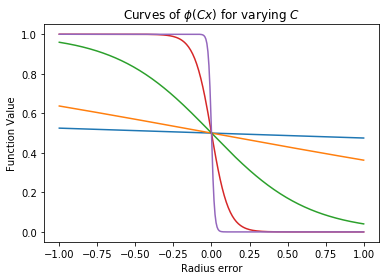

In [4]:
x = linspace(-1, 1, 300)
for l in logspace(-1, 2, 5):
    plot(x, ϕ(l*x))

title('Curves of $\phi(Cx)$ for varying $C$')
xlabel('Radius error')
ylabel('Function Value')

A simple initial test using just a circle at point $(0,0)$ with radius $1/2$

In [5]:
N_points = 100
points = np.zeros((2, N_points)) # the initial set of points
points[0,:] = np.linspace(-1, 1, N_points)

circ_pos = np.array([0, 0.1])[:,newaxis]
circ_radius2 = np.array([(1/2.)**2])

In [25]:
vec_ϕ = np.vectorize(ϕ)
vec_dϕ = np.vectorize(dϕ)

def compute_loss(curr_pos, circ_mat, circ_rad, C):
    all_dist = C*(linalg.norm(circ_mat - curr_pos[:,newaxis], axis=0)**2/circ_rad - 1)
    return np.sum(ϕ(all_dist))
    
def loss(pos_mat, circ_mat, circ_rad, C):
    return np.sum(np.apply_along_axis(lambda x: compute_loss(x, circ_mat, circ_rad, C), 0, pos_mat))

def compute_dloss(curr_pos, circ_mat, circ_rad, C):
    dif_mat = curr_pos[:,newaxis] - circ_mat
    all_dist = C*(linalg.norm(dif_mat, axis=0)**2/circ_rad - 1)
    return 2*C*np.sum(dϕ(all_dist)*dif_mat/circ_rad, axis=1)

def dloss(pos_mat, circ_mat, circ_rad, C):
    return np.apply_along_axis(lambda x: compute_dloss(x, circ_mat, circ_rad, C), 0, pos_mat)

def complete_dloss(pos_mat, circ_mat, circ_rad, C, K):
    dloss_obstacles = dloss(pos_mat, circ_mat, circ_rad, C)[:,1:-1]
    diff_mat = -pos_mat[:,:-2] + 2*pos_mat[:,1:-1] - pos_mat[:,2:]
    zeros_mat = np.zeros(2)[:,newaxis]
    return np.c_[zeros_mat, dloss_obstacles + K*diff_mat, zeros_mat]

def complete_loss(pos_mat, circ_mat, circ_rad, C, K):
    loss_obstacles = loss(pos_mat, circ_mat, circ_rad, C)
    loss_diff = sum(linalg.norm(pos_mat[:,1:] - pos_mat[:,:-1], axis=0))
    return loss_obstacles + K*loss_diff


Plot the initial path guess

In [27]:
def plot_path(points, circles, radii, plot_title=''):
    plot(points[0,:], points[1,:], '-')
    for idx in range(len(radii)):
        curr_cirlce = circle(circles[0, idx], circles[1, idx], radii[idx])
        plot(curr_cirlce[0], curr_cirlce[1], 'r')
        
    gca().set_aspect('equal')
    title(plot_title)
    xlim(-1, 1)
    ylim(-.7, .7)

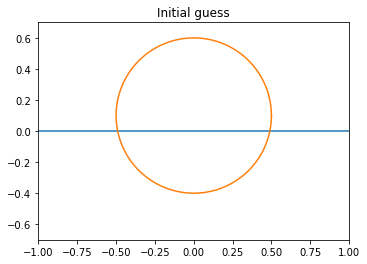

In [183]:
plot_path(points, circ_pos, sqrt(circ_radius2), 'Initial guess')

Optimize that ish

In [ ]:
MAX_ITER = 500
INIT_STEP_SIZE = 1e-1
COOLING_SCHEDULE = 1.005
INIT_CONSTRAINT_HARDNESS = 10

curr_pos = copy(points)
constraint_hardness = INIT_CONSTRAINT_HARDNESS

count = 0

for i in range(MAX_ITER+1):
    curr_pos -= INIT_STEP_SIZE*dloss(curr_pos, circ_pos, circ_radius2, constraint_hardness)
    constraint_hardness *= COOLING_SCHEDULE
    
    if i%5==0:
        plot_path(curr_pos, circ_pos, sqrt(circ_radius2), 'Iteration: {}'.format(i))
        savefig('simple_step/iter{:02d}.png'.format(count))
        close()
        count += 1
        

In [69]:
MAX_ITER = 1000
INIT_STEP_SIZE = 1e-3
MIN_STEP = 1e-13
COOLING_SCHEDULE = 1.01
FAST_COOLING_SCHEDULE = 2
INIT_CONSTRAINT_HARDNESS = 1
INIT_SPRING_HARDNESS = 100
MAX_TIME_INCREASE = 20

curr_pos = copy(points)
constraint_hardness = INIT_CONSTRAINT_HARDNESS

circ_pos = array([[-.5, .1], [-.15, -.5], [.25, .25], [.5, -.05], [-.25, .5]]).T
circ_radius2 = array([.2, .4, .25, .2, .25])**2

count = 0
curr_step = INIT_STEP_SIZE
prev_loss = float('inf')
momentum = .1

prev_velocity = np.zeros(curr_pos.shape)
curr_velocity = copy(prev_velocity)

times_increased = 0
converged = False

for i in range(MAX_ITER+1):
    while True:
        curr_velocity = momentum * prev_velocity - curr_step*complete_dloss(curr_pos, circ_pos, circ_radius2, constraint_hardness, INIT_SPRING_HARDNESS)
        proposed_pos = curr_pos + curr_velocity
        curr_loss = complete_loss(proposed_pos, circ_pos, circ_radius2, constraint_hardness, INIT_SPRING_HARDNESS)
        if curr_loss < prev_loss:
            curr_pos = proposed_pos
            prev_velocity = curr_velocity
            prev_loss = curr_loss
            curr_step *= 2
            times_increased = 0
            break
        else:
            curr_step *= .8
        if curr_step < MIN_STEP:
            if times_increased > MAX_TIME_INCREASE:
                print('Cooling schedule is finished. Converged to final result.')
                converged = True
                break
            print('Converged in cooling step; increasing schedule (C={})'.format(constraint_hardness))
            constraint_hardness *= FAST_COOLING_SCHEDULE
            times_increased += 1
#             raise ValueError('No decreasing step found for tol {}'.format(curr_step))

    if converged:
        break
    constraint_hardness *= COOLING_SCHEDULE
    
    
    if i%10==0:
        plot_path(curr_pos, circ_pos, sqrt(circ_radius2), 'Iteration: {}'.format(i))
        savefig('image_output/spring_backtracking_momentum/iter{:02d}.png'.format(count))
        close()
        count += 1
        print('On iteration {}'.format(i))
        print('Current step size : {}'.format(curr_step))
        

On iteration 0
Current step size : 0.002
On iteration 10
Current step size : 0.004951760157141529
On iteration 20
Current step size : 0.002571100870814394
On iteration 30
Current step size : 0.0016687398718132206
On iteration 40
Current step size : 0.0013538426240824394
On iteration 50
Current step size : 0.0010983676256209082
On iteration 60
Current step size : 0.0008911016831293453
On iteration 70
Current step size : 0.0009036844667866412
On iteration 80
Current step size : 0.0009164449253912121
On iteration 90
Current step size : 0.0009293855677986294
On iteration 100
Current step size : 0.0011781361728633883
On iteration 110
Current step size : 0.0018668312833510809
On iteration 120
Current step size : 0.0036976403076013076
On iteration 130
Current step size : 0.005859144944198626
On iteration 140
Current step size : 0.014506540244799993
On iteration 150
Current step size : 0.007532226334128419
On iteration 160
Current step size : 0.007638584986810227
On iteration 170
Current step 

/Users/Guille/Documents/Stanford/Personal/AUVSI/path-planning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Users/Guille/Documents/Stanford/Personal/AUVSI/path-planning/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  



Current step size : 0.006932803364399128
On iteration 260
Current step size : 0.007030697876915887
On iteration 270
Current step size : 0.007129974706956622
On iteration 280
Current step size : 0.007230653373508533
On iteration 290
Current step size : 0.009165942088970376
On iteration 300
Current step size : 0.009295369592592403
On iteration 310
Current step size : 0.009426624674714406
On iteration 320
Current step size : 0.009559733141622381
On iteration 330
Current step size : 0.009694721163999463
On iteration 340
Current step size : 0.00983161528207141
On iteration 350
Current step size : 0.007976353928659764
On iteration 360
Current step size : 0.008088983876238687
On iteration 370
Current step size : 0.008203204212760365
On iteration 380
Current step size : 0.008319037395280346
On iteration 390
Current step size : 0.008436506197958589
On iteration 400
Current step size : 0.008555633716537123
On iteration 410
Current step size : 0.006941154698304757
On iteration 420
Current step s

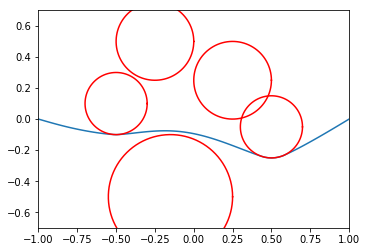

In [66]:
plot_path(curr_pos, circ_pos, sqrt(circ_radius2))